In [1]:
!pip install mesa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model

# Debido a que necesitamos que exista más de un agente por celda, elegimos ''MultiGrid''.
from mesa.space import MultiGrid

# Con ''RandomActivation'', hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime
MAXVAL = 10000

In [3]:
#Creamos los agentes "Hoover" (Aspiradora).
class HooverAgent(Agent):
  def __init__(self, id, model):
    super().__init__(id, model)
    self.totalMoves = 0

#Dejamos que la aspiradora se mueva a cualquiera de las 8 celdas continuas.
  def move(self):
    #Declaramos las opciones para moverse (vecinos usando moore y sin contar la casilla en la que se encuentra el agente)
    options=self.model.grid.get_neighborhood(self.pos,moore = True, include_center=False)
    #El agente selecciona una de las casillas de opción aleatoriamente para moverse
    self.model.grid.move_agent(self,self.random.choice(options))
    #Llevamos la cuenta de cuantos pasos ha dado cada aspiradora.
    self.totalMoves= self.totalMoves + 1

#Función para limpiar la casilla:
  def clean(self):
    #Si la celda en la que se encuentra la aspiradora está sucia (== 1) la aspiradora la deja limpia (0)
    if self.model.cells[self.pos[0]] [self.pos[1]] == 1:
      self.model.cells[self.pos[0]] [self.pos[1]] = 0

#Función que lleva a cabo los pasos de la simulación (clean y move)
  def step(self):
    self.clean()
    self.move()

In [4]:
#Función para dibujar una cuadrícula que nos permitirá visualizar nuestro modelo
def getGrid(model):
    #Creamos una matriz vacía (zeros) con las dimensiones de width y height (2D)
    grid=np.zeros( (model.grid.width, model.grid.height))
    for x in range(model.grid.width):
      for y in range(model.grid.height):
        #Asignamos las celdas usando sus coordenadas (x,y) para determinar su posición
        grid[x][y] = model.cells[x][y]
        #Si la celda no está vacía, asigna el valor 2 a la posición (x, y) de la cuadrícula.
        if not model.grid.is_cell_empty((x,y)):
          grid[x][y] = 2
        #Si la celda está vacía, asigna el valor original de la celda del modelo a la posición (x, y)
        else:
          grid[x][y] = model.cells[x][y]
    #Regresar la matriz acomodada
    return grid

In [5]:
#Creamos el modelo para la Hoover (Aspiradora)
class HooverModel(Model):
  def __init__(self, width, height, numAgents=1, maxSteps=100, dirtyCellsPercentage = np.random.random):
    super().__init__()
    self.numAgents = numAgents
    self.dirtyCellsPercentage = dirtyCellsPercentage
    self.grid = MultiGrid(width, height, False)
    self.schedule = RandomActivation(self)
    self.dataCollector = DataCollector(model_reporters = {"Grid" : getGrid })
    self.cells = np.zeros((width, height))
    self.visitedCells = np.zeros((width, height))
    self.maxSteps = maxSteps
    self.currentStep = 0
    self.timeNeeded = None
    self.cleanPercentage = None
    self.totalMoves = None

    #Calculamos la cantidad de celdas que estarán sucias en base al porcentaje (80%)
    amount = int ( (width * height) * self.dirtyCellsPercentage)
    for i in range(amount):
      #Mientras sigan habiendo celdas sucias, no hemos terminado
      finished = False
      #Mientras no hayamos terminado, seguiremos buscando coordenadas a las cuales movernos, mientras estén dentro de los límites.
      while not finished:
        x = int (np.random.random() * MAXVAL) % width
        y = int (np.random.random() * MAXVAL) % height
        if self.cells[x][y] == 0:
          self.cells[x][y] = 1
        #Si la celda en las coordenadas (x, y) no ha sido visitada (False),
        #la marca como visitada (True) y establece 'finished' como True para salir del bucle while.
        if self.visitedCells[x][y] == False:
          self.visitedCells[x][y] = True
          finished = True

    #Creamos los agentes y los colocamos en la casilla (1,1)
    for i in range(self.numAgents):
      x = self.random.randrange(self.grid.width)
      y = self.random.randrange(self.grid.height)
      agent = HooverAgent(i, self)
      self.grid.place_agent(agent, (x,y))
      self.schedule.add(agent)

#Determinamos si ya todas las celdas están limpias
  def allClean(self):
    return np.all(self.cells == 0)

#Función que lleva a cabo los pasos de la simulación
  def step(self):
    self.dataCollector.collect(self)
    self.schedule.step()
    self.currentStep += 1
    if self.currentStep >= self.maxSteps or self.allClean():
      self.timeNeeded = self.currentStep
      self.cleanPercentage = (np.count_nonzero(self.cells == 0) / (self.grid.width * self.grid.height)) * 100
      self.totalMoves = sum(agent.totalMoves for agent in self.schedule.agents)
      self.running = False

In [14]:
#Definimos valores de las variables necesarias para coordinar y componer el modelo
GRID_SIZE = 20

MAX_ITER = 1000

AGENT_NUM= 10

DIRTY_CELLS_PERCENTAGE = 0.80

startTime = time.time()

model = HooverModel(GRID_SIZE, GRID_SIZE, AGENT_NUM, MAX_ITER, DIRTY_CELLS_PERCENTAGE)

i = 0
while i < MAX_ITER and not model.allClean():
  model.step()
  i = i + 1

In [17]:
#Despliege de los datos importantes.
totalTime = time.time() - startTime
#Imprimir el tiempo de ejecución de la simulación
print('Tiempo de ejecucion: %.5f segundos' % totalTime)
#Imprimir la cantidad de Steps necesarios para acabar de limpiar
print(f'Cantidad de Steps para que todas las celdas estén limpias: {model.timeNeeded} Steps')
#Imprimir porcentaje limpio al finalizar la simulación
print(f'Porcentaje de celdas limpias después del término de la simulación: {model.cleanPercentage}%')
#Imprimir cantidad total de movimientos por agentes
print(f'Cantidad total de movimientos realizados por los agentes: {model.totalMoves}')

Tiempo de ejecucion: 221.98775 segundos
Cantidad de Steps para que todas las celdas estén limpias: 480 Steps
Porcentaje de celdas limpias después del término de la simulación: 100.0%
Cantidad total de movimientos realizados por los agentes: 4800


In [18]:
#Imprimimos toda la matriz de datos
all_grid = model.dataCollector.get_model_vars_dataframe()
print(all_grid)

                                                  Grid
0    [[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0,...
1    [[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0,...
2    [[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0,...
3    [[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0,...
4    [[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0,...
..                                                 ...
475  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
476  [[0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0,...
477  [[0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
478  [[0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0,...
479  [[0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

[480 rows x 1 columns]


Working...


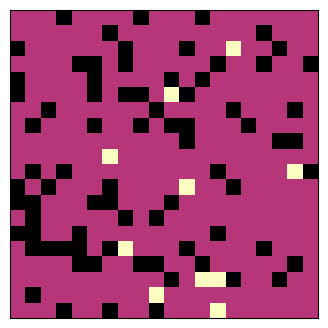

In [21]:
#Registramos los movimientos de los agentes en los steps y los animamos
#Asignamos el tamaño de la animación
fig, axs=plt.subplots(figsize=(4,4))
axs.set_xticks([])
axs.set_yticks([])

#Comprobamos que la matriz tenga datos
if not all_grid.empty:
  print("Working...")
  #Mostrar visualización de la simulación
  patch = plt.imshow(all_grid.iloc[0][0], cmap='magma')
else:
  #Si no hay datos, imprimimos un mensaje de error...
  print("ERROR: NO DATA")
  #... y la matriz vacía
  patch = plt.imshow(np.zeros((model.grid.width, model.grid.height)), cmap='magma')

#Animamos / Dibujamos la matriz con los datos que tenemos
def animate(i):
  #Mientras no se estén pasando los límites de la grid
  if i < len(all_grid):
    #Actualizar estados
    patch.set_data(all_grid.iloc[i][0])
  else:
    #Si no, mostramos el último estado
    patch.set_data(all_grid.iloc[-1][0])

#Mostramos la matriz como tal
anim = animation.FuncAnimation(fig, animate, frames=MAX_ITER, repeat=False)
plt.show()

In [22]:
#Ahora le añadimos movimiento y representación visual a nuestra simulación
anim